In [1]:
pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

  Using cached https://github.com/PythonOT/POT/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from time import time
import ot

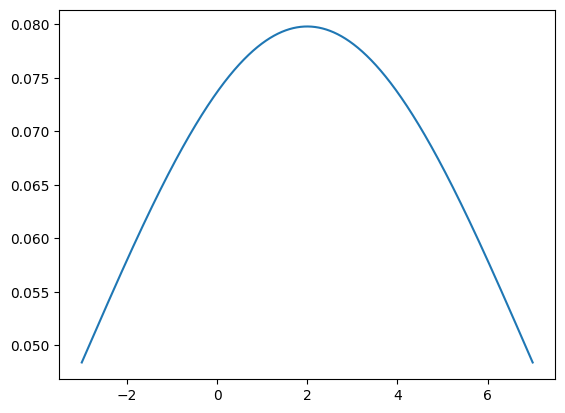

In [3]:
# make a plot for target distribution
mu,sigma = 2,5
num_samples = 10000
xs = np.linspace(-3, 7, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
plt.plot(xs, samples)

# Ganerative Adversarial Network Framework
1.Generate Target and random distribution.
2.Define Network Architecture.

In [4]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()

        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.uniform(-0.1,0.1,num_samples)*10 # Random floats with uniform dist. in the interval [0.0, 0.01)
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset

        return samples

In [5]:
# three layer NN
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        # Fully-connected layer
        fc = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight)
        nn.init.constant_(fc.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc, nn.ReLU())
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.0)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)

        return out

In [6]:
# three layer NN
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()

        # Fully-connected layer
        fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc1.weight)
        nn.init.constant_(fc1.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc1, nn.ReLU())
        # Fully-connected layer
        fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc2.weight)
        nn.init.constant_(fc2.bias, 0.0)
        # Output layer
        self.output_layer = nn.Sequential(fc2, nn.Sigmoid()) ## binary classification

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)

        return out

# Network Train
1.Initialize Hyper-parameter
2.Use RMSPOP in wGAN paper to train
3.plot the result

In [7]:
# Hyper-parameters
# mu, sigma are target distribution mean and variance.
mu = 20.0
sigma = 100.0
# data range is used for plotting.
data_range = 100
batch_size = 150

input_dim = 1
hidden_dim = 128
output_dim = 1

num_epochs = 1000
learning_rate = 0.0005
clip_value=0.01 # lower and upper clip value for disc. weights
n_critic = 5
cuda = True if torch.cuda.is_available() else False
num_samples = 10000
num_bins = 30

# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim)
# Loss function (WGAN loss)

In [8]:
# Optimizers
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=learning_rate)
d_optimizer = torch.optim.RMSprop(D.parameters(), lr=learning_rate)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

g_loss_list = []
d_loss_list = []

wass_list = []
approx = []
batches_done = 0
saved_imgs = []
for epoch in range(num_epochs):
    #print('Epoch ' + str(epoch) + ' training...' , end=' \n')

    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size,input_dim])))
    y_real_ = Variable(torch.ones([batch_size,input_dim]))
    y_fake_ =  Variable(torch.zeros([batch_size, input_dim]))
    # Train discriminator with real data
    d_real_decision = D(x_)
    d_real_loss = torch.mean(d_real_decision)


    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_,[batch_size, input_dim])))
    z_ = G(z_)
    d_fake_decision = D(z_)
    d_fake_loss = torch.mean(d_fake_decision)

    #fake_data = d_fake_decision.detach()
    # train Discriminator
    # sample noise as generator input

    # generate a batch of images
    # Adversarial loss train
    d_loss = d_fake_loss - d_real_loss
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    # clip weights of discriminator
    for p in D.parameters():
        p.data.clamp_(-1*clip_value,clip_value )

    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_,[batch_size,input_dim])))
    z_ = G(z_)
    # record batch of fake data

    d_fake_decision = D(z_)
    # loss function
    g_loss = -torch.mean(d_fake_decision)

    # train Generator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    g_loss.backward()
    g_optimizer.step()
    #batches_done += 1
    end = time()
    d_loss_list.append(d_loss.item())
    g_loss_list.append(g_loss.item())
    # compute Wasserstein distance and loss here.
    if epoch % 5 == 0:
        with torch.no_grad():
            critics_fake_data_ = z_.detach().numpy()
            critics_fake_data,_ = np.histogram(critics_fake_data_, num_bins, density=True)
            #print(critics_fake_data.shape)
            true_data_ = x_.detach().numpy()
            true_data,_ = np.histogram(true_data_ , num_bins, density=True)

            #plt.hist(critics_fake_data.numpy(),bins=50, density=True, alpha=0.6, color='g')
            #plt.title(f"Epoch {epoch}")
            #plt.xlabel("Generated Data Value")
            #plt.ylabel("Density")
            #plt.show()
            bins = np.arange(num_bins, dtype=np.float64)
            # loss matrix
            M = ot.dist(bins.reshape((num_bins, 1)), bins.reshape((num_bins, 1)))
            M /= M.max()
            reg = 0.01
            ot_plan = ot.sinkhorn(true_data,critics_fake_data,M,reg)
            wass_dist = np.sum(np.multiply(M,ot_plan))
            wass_list.append(wass_dist)
            approx.append(-1*d_loss.item())
            print('epoch:{}, D loss:{}, G loss:{}\n'.format(epoch, d_loss.item(), d_loss.item()))
            print('epoch:{}, approximate_wass:{}, wass:{}\n'.format(epoch, np.abs(d_loss.item()), wass_dist))

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:491: RuntimeWarning: divide by zero encountered in divide
  Kp = (1 / a).reshape(-1, 1) * K
/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


epoch:0, D loss:-0.3931559920310974, G loss:-0.3931559920310974

epoch:0, approximate_wass:0.3931559920310974, wass:0.0013391577930281563

epoch:5, D loss:-0.0860719382762909, G loss:-0.0860719382762909

epoch:5, approximate_wass:0.0860719382762909, wass:0.0029187052285730296



/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 653
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 611
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:10, D loss:-0.014848679304122925, G loss:-0.014848679304122925

epoch:10, approximate_wass:0.014848679304122925, wass:0.0035255637910006133

epoch:15, D loss:0.013972342014312744, G loss:0.013972342014312744

epoch:15, approximate_wass:0.013972342014312744, wass:0.001251356031468529



/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 831
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 622
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:20, D loss:0.011705279350280762, G loss:0.011705279350280762

epoch:20, approximate_wass:0.011705279350280762, wass:0.0011363053480707504

epoch:25, D loss:-0.00324171781539917, G loss:-0.00324171781539917

epoch:25, approximate_wass:0.00324171781539917, wass:0.001282620900668087

epoch:30, D loss:-0.01293492317199707, G loss:-0.01293492317199707

epoch:30, approximate_wass:0.01293492317199707, wass:0.0015091914695607445

epoch:35, D loss:-0.009003698825836182, G loss:-0.009003698825836182

epoch:35, approximate_wass:0.009003698825836182, wass:0.0009692124230460123

epoch:40, D loss:0.002038121223449707, G loss:0.002038121223449707

epoch:40, approximate_wass:0.002038121223449707, wass:0.0010386506296033036

epoch:45, D loss:0.016396164894104004, G loss:0.016396164894104004

epoch:45, approximate_wass:0.016396164894104004, wass:0.001281817545936238

epoch:50, D loss:0.003664851188659668, G loss:0.003664851188659668

epoch:50, approximate_wass:0.003664851188659668, wass:0.00137058

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 981
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 990
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:435, D loss:-0.0007811784744262695, G loss:-0.0007811784744262695

epoch:435, approximate_wass:0.0007811784744262695, wass:0.0013977730972147724

epoch:440, D loss:-0.0013228654861450195, G loss:-0.0013228654861450195

epoch:440, approximate_wass:0.0013228654861450195, wass:0.0010232725292007468

epoch:445, D loss:-0.0008299946784973145, G loss:-0.0008299946784973145

epoch:445, approximate_wass:0.0008299946784973145, wass:0.0021012496094068123

epoch:450, D loss:0.0001767277717590332, G loss:0.0001767277717590332

epoch:450, approximate_wass:0.0001767277717590332, wass:0.0011425255948937503

epoch:455, D loss:-0.0011928677558898926, G loss:-0.0011928677558898926

epoch:455, approximate_wass:0.0011928677558898926, wass:0.0015171704491781525

epoch:460, D loss:0.0013169050216674805, G loss:0.0013169050216674805

epoch:460, approximate_wass:0.0013169050216674805, wass:0.0011381270393213982

epoch:465, D loss:0.00039499998092651367, G loss:0.00039499998092651367

epoch:465, approxim

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 952
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:545, D loss:-0.00115966796875, G loss:-0.00115966796875

epoch:545, approximate_wass:0.00115966796875, wass:0.0020495795579298587

epoch:550, D loss:0.00026929378509521484, G loss:0.00026929378509521484

epoch:550, approximate_wass:0.00026929378509521484, wass:0.0011206248371005924

epoch:555, D loss:0.0007137060165405273, G loss:0.0007137060165405273

epoch:555, approximate_wass:0.0007137060165405273, wass:0.001193616369195878

epoch:560, D loss:9.97781753540039e-05, G loss:9.97781753540039e-05

epoch:560, approximate_wass:9.97781753540039e-05, wass:0.0009127936306755962

epoch:565, D loss:-8.809566497802734e-05, G loss:-8.809566497802734e-05

epoch:565, approximate_wass:8.809566497802734e-05, wass:0.0026561713715193853

epoch:570, D loss:8.589029312133789e-05, G loss:8.589029312133789e-05

epoch:570, approximate_wass:8.589029312133789e-05, wass:0.001850441102187943

epoch:575, D loss:-0.0001074075698852539, G loss:-0.0001074075698852539

epoch:575, approximate_wass:0.0001074075

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 970
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:730, D loss:0.0006316304206848145, G loss:0.0006316304206848145

epoch:730, approximate_wass:0.0006316304206848145, wass:0.0017632453225295578

epoch:735, D loss:-0.0007991194725036621, G loss:-0.0007991194725036621

epoch:735, approximate_wass:0.0007991194725036621, wass:0.0014344995970657962

epoch:740, D loss:0.0008448958396911621, G loss:0.0008448958396911621

epoch:740, approximate_wass:0.0008448958396911621, wass:0.0016494267299090315

epoch:745, D loss:0.00022739171981811523, G loss:0.00022739171981811523

epoch:745, approximate_wass:0.00022739171981811523, wass:0.0014018238541912335

epoch:750, D loss:0.00015217065811157227, G loss:0.00015217065811157227

epoch:750, approximate_wass:0.00015217065811157227, wass:0.001594083863564647

epoch:755, D loss:-0.00012508034706115723, G loss:-0.00012508034706115723

epoch:755, approximate_wass:0.00012508034706115723, wass:0.0028196651368969368

epoch:760, D loss:-0.00018280744552612305, G loss:-0.00018280744552612305

epoch:760, ap

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 992
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:800, D loss:-0.00012159347534179688, G loss:-0.00012159347534179688

epoch:800, approximate_wass:0.00012159347534179688, wass:0.0014154369074049216

epoch:805, D loss:-7.092952728271484e-06, G loss:-7.092952728271484e-06

epoch:805, approximate_wass:7.092952728271484e-06, wass:0.0015509071898032795

epoch:810, D loss:-6.705522537231445e-05, G loss:-6.705522537231445e-05

epoch:810, approximate_wass:6.705522537231445e-05, wass:0.0013219018470647255

epoch:815, D loss:-0.00016415119171142578, G loss:-0.00016415119171142578

epoch:815, approximate_wass:0.00016415119171142578, wass:0.001280113630188863

epoch:820, D loss:-4.8607587814331055e-05, G loss:-4.8607587814331055e-05

epoch:820, approximate_wass:4.8607587814331055e-05, wass:0.0016094271458282124

epoch:825, D loss:0.0009726881980895996, G loss:0.0009726881980895996

epoch:825, approximate_wass:0.0009726881980895996, wass:0.0024396350481958144

epoch:830, D loss:-0.0005396008491516113, G loss:-0.0005396008491516113



/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 941
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:830, approximate_wass:0.0005396008491516113, wass:0.0014833511833565816

epoch:835, D loss:-1.519918441772461e-05, G loss:-1.519918441772461e-05

epoch:835, approximate_wass:1.519918441772461e-05, wass:0.001547266451110379

epoch:840, D loss:0.00045675039291381836, G loss:0.00045675039291381836

epoch:840, approximate_wass:0.00045675039291381836, wass:0.0013068878955907262

epoch:845, D loss:0.00014317035675048828, G loss:0.00014317035675048828

epoch:845, approximate_wass:0.00014317035675048828, wass:0.0016526122932670503

epoch:850, D loss:0.0005932450294494629, G loss:0.0005932450294494629

epoch:850, approximate_wass:0.0005932450294494629, wass:0.0011620660535086493

epoch:855, D loss:7.003545761108398e-05, G loss:7.003545761108398e-05

epoch:855, approximate_wass:7.003545761108398e-05, wass:0.001976486011637213

epoch:860, D loss:-0.0004354715347290039, G loss:-0.0004354715347290039

epoch:860, approximate_wass:0.0004354715347290039, wass:0.0018429749931531238



/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 924
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


epoch:865, D loss:0.00013262033462524414, G loss:0.00013262033462524414

epoch:865, approximate_wass:0.00013262033462524414, wass:0.0013470348847551177

epoch:870, D loss:0.0006448030471801758, G loss:0.0006448030471801758

epoch:870, approximate_wass:0.0006448030471801758, wass:0.0018656524531409043

epoch:875, D loss:-6.705522537231445e-05, G loss:-6.705522537231445e-05

epoch:875, approximate_wass:6.705522537231445e-05, wass:0.0010529855541375303

epoch:880, D loss:-0.00032329559326171875, G loss:-0.00032329559326171875

epoch:880, approximate_wass:0.00032329559326171875, wass:0.0009836956842401825

epoch:885, D loss:-0.00030541419982910156, G loss:-0.00030541419982910156

epoch:885, approximate_wass:0.00030541419982910156, wass:0.0013468665476796852

epoch:890, D loss:9.489059448242188e-05, G loss:9.489059448242188e-05

epoch:890, approximate_wass:9.489059448242188e-05, wass:0.00160718986979455

epoch:895, D loss:-0.0001742839813232422, G loss:-0.0001742839813232422

epoch:895, app

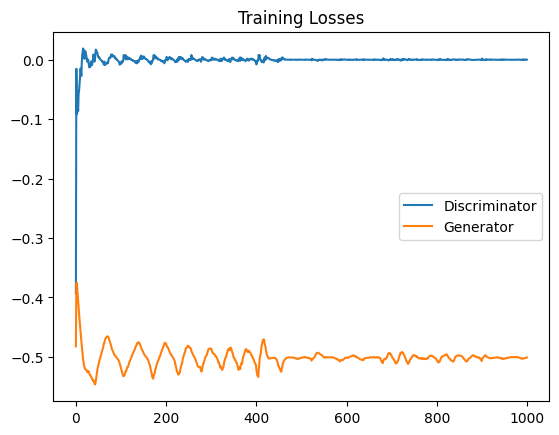

In [9]:
# train loss plot
fig, ax = plt.subplots()
D_losses = np.array(d_loss_list)
G_losses = np.array(g_loss_list)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
#
plt.title("Training Losses")
plt.legend()
plt.show()

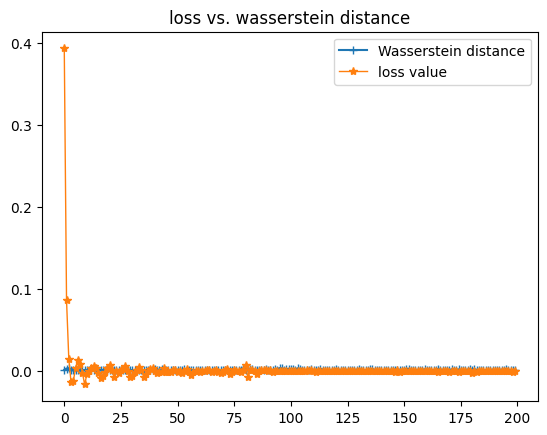

In [10]:
# wasserstein vs.loss
fig, ax = plt.subplots()
plt.plot(wass_list,'-+',label = "Wasserstein distance",linewidth = 1.5)
plt.plot(approx, '-*',label = 'loss value',linewidth = 1)
plt.title("loss vs. wasserstein distance")
plt.legend()
plt.show()

0.24499999999999997
